Should we calculate difference? https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

Convert wind dirs to degrees for numerical values? https://study.com/cimages/multimages/16/cb_1_copy.jpeg
    - No: convert to direction vector: https://www.tensorflow.org/tutorials/structured_data/time_series
    
Major issue to resolve - data is not strictly time series as it contains the data from many sites over time, with overlapping time frames. How to prevent model from considering one site's time series data as an extension of the previous site's?

In [187]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('weatherAUS.csv')
# data.info()

In [191]:
data['Location'].value_counts()

Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3090
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Ballarat            3028
Launceston          3028
Albany              3016
Albury              3011
PerthAirport        3009
MelbourneAirport    3009
Mildura             3007
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cairns              2988
Cobar               2988
Wollongong          2983
GoldCoast           2980
WaggaWagga          2976
Penrith             2964
NorfolkIsland       2964
SalmonGums          2955
Newcastle           2955
CoffsHarbour        2953
Witchcliffe         2952
Richmond            2951
Dartmoor            2943
NorahHead           2929
BadgerysCreek       2928


In [108]:
(data.isna().sum() / data.shape[0]) * 100 # what percent of each column is NA?
data["RainTomorrow"].value_counts() # our data is not balanced between classes

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [168]:
# convert to binary
data["RainTomorrow"].replace(('Yes', 'No'), (1, 0), inplace=True)
data["RainToday"].replace(('Yes', 'No'), (1, 0), inplace=True)
data.drop(columns=['Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], inplace=True)

# convert direction strings to degrees
data['WindGustDir'].replace(
    ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
    (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
    inplace=True
)

data['WindDir9am'].replace(
    ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
    (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
    inplace=True
)

data['WindDir3pm'].replace(
    ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
    (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
    inplace=True
)

In [169]:
# drop na in listed columns
data.dropna(
    axis=0, how='any',
    subset=['WindGustDir','WindDir9am','WindDir3pm','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'],
    inplace=True
)

data_date = pd.to_datetime(data.pop('Date'))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

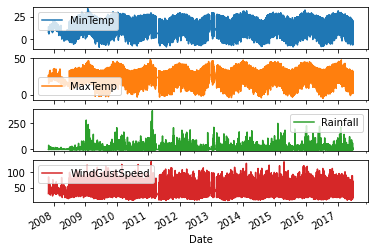

In [170]:
# plot features over time
plot_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed']
plot_features = data[plot_cols]
plot_features.index = data_date
plot_features.plot(subplots=True)

In [100]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MinTemp,141556.0,12.186400,6.403283,-8.5,7.6,12.0,16.8,33.9
MaxTemp,141871.0,23.226784,7.117618,-4.8,17.9,22.6,28.2,48.1
Rainfall,140787.0,2.349974,8.465173,0.0,0.0,0.0,0.8,371.0
Evaporation,81350.0,5.469824,4.188537,0.0,2.6,4.8,7.4,145.0
Sunshine,74377.0,7.624853,3.781525,0.0,4.9,8.5,10.6,14.5
WindGustSpeed,132923.0,39.984292,13.588801,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,140845.0,14.001988,8.893337,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,139563.0,18.637576,8.803345,0.0,13.0,19.0,24.0,87.0
Humidity9am,140419.0,68.843810,19.051293,0.0,57.0,70.0,83.0,100.0
Humidity3pm,138583.0,51.482606,20.797772,0.0,37.0,52.0,66.0,100.0


Text(0, 0.5, 'Wind Velocity [m/s]')

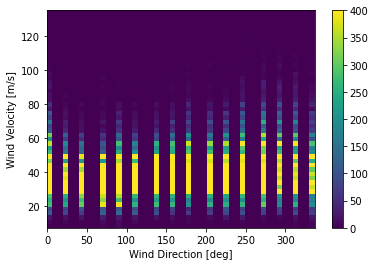

In [142]:
# plot distribution of wind data
plt.hist2d(data['WindGustDir'], data['WindGustSpeed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [160]:
# convert all wind data to vectors
wv = data.pop('WindGustSpeed')
wd = data.pop('WindGustDir')*np.pi/180
data['WindGustX'] = wv*np.cos(wd)
data['WindGustY'] = wv*np.sin(wd)

wv = data.pop('WindSpeed9am')
wd = data.pop('WindDir9am')*np.pi/180
data['Wind9amX'] = wv*np.cos(wd)
data['Wind9amY'] = wv*np.sin(wd)

wv = data.pop('WindSpeed3pm')
wd = data.pop('WindDir3pm')*np.pi/180
data['Wind3pmX'] = wv*np.cos(wd)
data['Wind3pmY'] = wv*np.sin(wd)

(-135.0, 107.0, -126.0, 135.0)

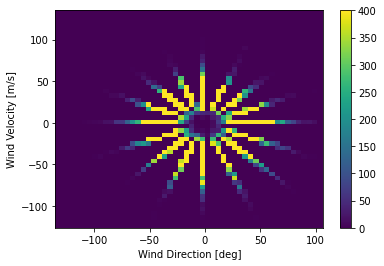

In [113]:
# plot distribution of new wind vectors
plt.hist2d(data['WindGustX'], data['WindGustY'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
ax = plt.gca()
ax.axis('tight')

In [171]:
timestamp_s = data_date.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day
data['daysin'] = np.sin(timestamp_s * (2 * np.pi/day))
data['daycos'] = np.cos(timestamp_s * (2 * np.pi/day))
data['yearsin'] = np.sin(timestamp_s * (2 * np.pi/year))
data['yearcos'] = np.cos(timestamp_s * (2 * np.pi/year))

In [172]:
# Normalize all the data
data_mean = data.mean()
data_std = data.std()

data = (data - data_mean) / data_std

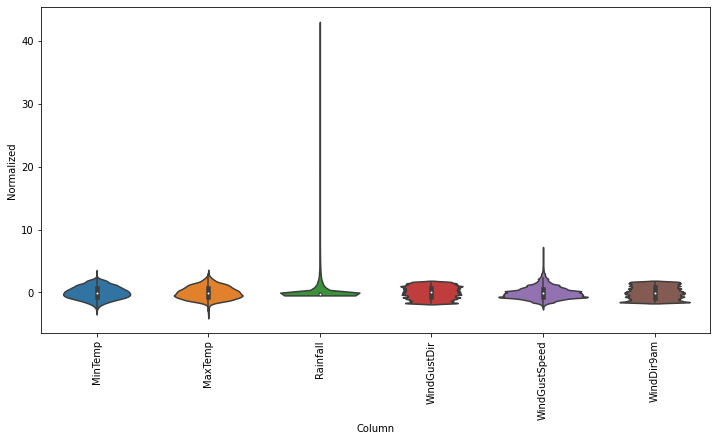

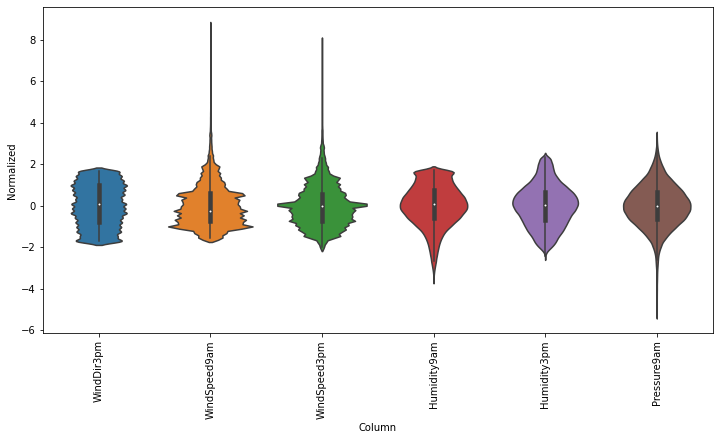

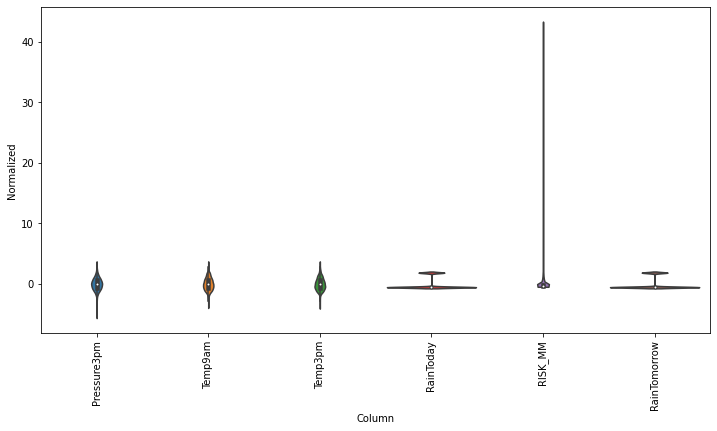

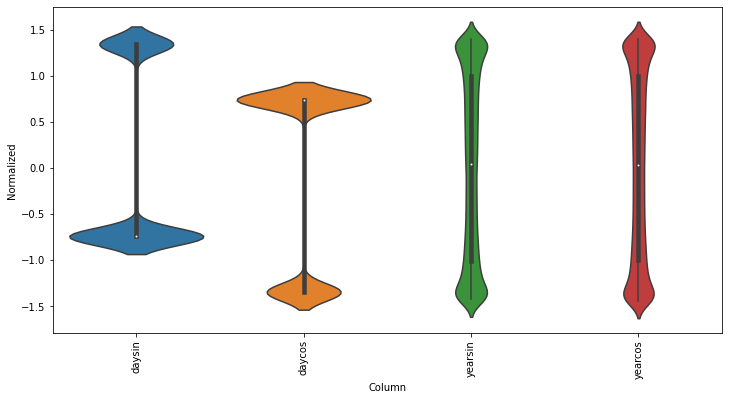

In [186]:
data_melted = data.melt(var_name='Column', value_name='Normalized')
var_rows = int(data_melted.shape[0]/22) # number of rows for each variable

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[:var_rows*6])
_ = ax.set_xticklabels(data.keys()[:6], rotation=90)

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[var_rows*6:var_rows*12])
_ = ax.set_xticklabels(data.keys()[6:12], rotation=90)

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[var_rows*12:var_rows*18])
_ = ax.set_xticklabels(data.keys()[12:18], rotation=90)

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[var_rows*18:var_rows*22])
_ = ax.set_xticklabels(data.keys()[18:22], rotation=90)